# ClinicalTrials.gov v2 → Portfolio Context & ROI Scenarios

This notebook uses the **v2 API** (`/api/v2/studies`) to:
1) Fetch trial metadata with **pagination** and local **cache**  
2) Build a **portfolio view** (status distribution, durations, enrollment)  
3) Feed a simple **ROI scenario** using `scripts/roi.py` (time saved, direct savings, EV uplift)

If the API is temporarily unavailable, the notebook falls back to a cached file.

In [1]:
import sys, os
# add project root (one level up from notebooks/)
sys.path.append(os.path.abspath(".."))

from scripts.scorecard import compute_basic_metrics, score, plot_scorecard

In [9]:
import os, json, time, requests, pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

from scripts.roi import TrialScenario, roi_summary  # <- your ROI helpers

pd.set_option("display.max_columns", 60)
DATA_DIR = Path("data"); DATA_DIR.mkdir(exist_ok=True)
print("Setup complete.")

Setup complete.


## 1) Fetch studies from ClinicalTrials.gov v2 (pagination + cache)

- Endpoint: `https://clinicaltrials.gov/api/v2/studies`  
- Params used: `query.cond`, `pageSize` (≤100), `nextPageToken`  
- We request a **subset size** (e.g., 300–500) for fast demos

In [11]:
BASE = "https://clinicaltrials.gov/api/v2/studies"

def fetch_studies_v2(condition="oncology", page_size=100, max_records=400, max_pages=10, sleep=0.3):
    """Paginated pull with a hard cap on total records & pages."""
    studies, page_token = [], None
    for page in range(max_pages):
        params = {"query.cond": condition, "pageSize": page_size}
        if page_token:
            params["pageToken"] = page_token
        r = requests.get(BASE, params=params, timeout=40)
        if r.status_code >= 500 or r.status_code == 429:
            # transient failure; wait & retry once
            time.sleep(1.0)
            r = requests.get(BASE, params=params, timeout=40)
        r.raise_for_status()
        payload = r.json()
        batch = payload.get("studies", [])
        studies.extend(batch)
        page_token = payload.get("nextPageToken")
        if not page_token or len(studies) >= max_records:
            break
        time.sleep(sleep)
    return studies[:max_records]

cache_json = DATA_DIR / "ctgov_v2_oncology.json"

try:
    studies = fetch_studies_v2(condition="oncology", page_size=100, max_records=400)
    if studies:
        cache_json.write_text(json.dumps(studies, indent=2))
        print(f"Fetched {len(studies)} studies and cached to {cache_json}")
    else:
        raise RuntimeError("Empty result from v2 API.")
except Exception as e:
    print("[warn] live fetch failed; using cache if available:", e)
    if cache_json.exists():
        studies = json.loads(cache_json.read_text())
        print(f"[info] Loaded {len(studies)} studies from cache.")
    else:
        studies = []
        print("[fallback] No cache found; downstream cells will handle empties.")
len(studies)

Fetched 400 studies and cached to data/ctgov_v2_oncology.json


400

## 2) Flatten v2 study objects → tidy DataFrame

The v2 API nests fields under `protocolSection.*Module`. We extract:
- `NCTId`, `OverallStatus`, `StartDate`, `CompletionDate`, `StudyType`, `Phases`, `EnrollmentCount`, `Conditions`
- Derive **duration (months)** when dates available

In [13]:
def to_dt(s):
    if not s: return None
    # v2 returns ISO dates like "2019-03" or "2019-03-15"
    for fmt in ("%Y-%m-%d", "%Y-%m"):
        try: return datetime.strptime(s, fmt)
        except Exception: pass
    # final attempt: just take year
    try: return datetime.strptime(s, "%Y")
    except Exception: return None

def flatten_study(study):
    ps = study.get("protocolSection", {}) or {}
    idm = ps.get("identificationModule", {}) or {}
    dm  = ps.get("designModule", {}) or {}
    sm  = ps.get("statusModule", {}) or {}
    cm  = ps.get("conditionsModule", {}) or {}

    nctid = idm.get("nctId")
    conds = "; ".join(cm.get("conditions", []) or [])
    overall = sm.get("overallStatus")
    start = (sm.get("startDateStruct") or {}).get("date")
    comp  = (sm.get("completionDateStruct") or {}).get("date")
    stype = dm.get("studyType")
    phases = dm.get("phases", []) or [None]
    phase = phases[0] if phases else None
    enr = (dm.get("enrollmentInfo") or {}).get("count")

    dt_start = to_dt(start)
    dt_comp  = to_dt(comp)
    dur_m = (dt_comp - dt_start).days/30.4 if (dt_start and dt_comp) else None

    return {
        "NCTId": nctid,
        "Condition": conds,
        "OverallStatus": overall,
        "StartDate": start,
        "CompletionDate": comp,
        "StudyType": stype,
        "Phase": phase,
        "EnrollmentCount": (int(enr) if isinstance(enr, (int, float, str)) and str(enr).isdigit() else None),
        "DurationMonths": dur_m
    }

df = pd.DataFrame([flatten_study(s) for s in studies]) if studies else pd.DataFrame(columns=[
    "NCTId","Condition","OverallStatus","StartDate","CompletionDate","StudyType","Phase","EnrollmentCount","DurationMonths"
])
df.head()

,NCTId,Condition,OverallStatus,StartDate,CompletionDate,StudyType,Phase,EnrollmentCount,DurationMonths
0,NCT01595087,Prostate Cancer Metastatic,COMPLETED,2012-01,2013-09,INTERVENTIONAL,PHASE1,28.0,20.032895
1,NCT06156787,Urinary Bladder Cancer,COMPLETED,2020-11-01,2022-04-10,OBSERVATIONAL,None,105.0,17.269737
2,NCT02736721,"Myelogenous Leukemia, Chronic",COMPLETED,2003-09,2010-11,INTERVENTIONAL,PHASE3,41.0,86.118421
3,NCT02689921,Breast Neoplasms,UNKNOWN,2016-04,2018-12,INTERVENTIONAL,PHASE2,7.0,32.039474
4,NCT05123287,"Plaque, Atherosclerotic; Immune Checkpoint Inh...",UNKNOWN,2021-10-08,2022-12-01,OBSERVATIONAL,None,50.0,13.782895


## 3) Portfolio view (status, durations, enrollment)

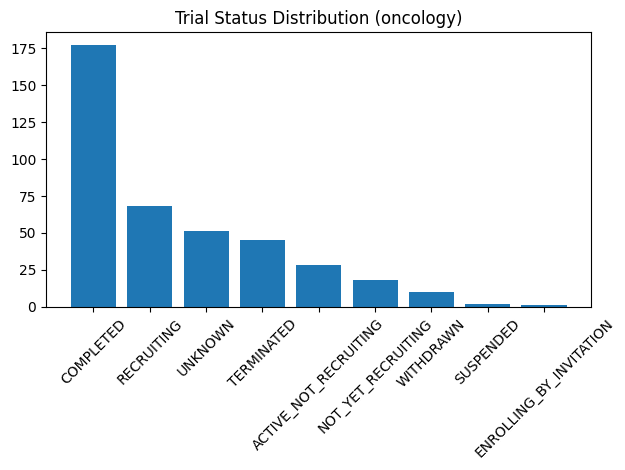

In [15]:
# Status distribution
status_counts = df["OverallStatus"].value_counts(dropna=False).sort_values(ascending=False)

fig, ax = plt.subplots()
ax.bar(status_counts.index.astype(str), status_counts.values)
ax.set_title("Trial Status Distribution (oncology)")
ax.tick_params(axis="x", rotation=45)
plt.tight_layout()

In [17]:
# Duration summary (months)
dur = df["DurationMonths"].dropna()
dur_desc = dur.describe(percentiles=[0.5])
dur_desc

count    387.000000
mean      52.399871
std       42.227660
min        0.065789
50%       39.736842
max      288.782895
Name: DurationMonths, dtype: float64

In [19]:
# Enrollment summary
enr = df["EnrollmentCount"].dropna()
enr_desc = enr.describe(percentiles=[0.5])
enr_desc

count       387.000000
mean        691.356589
std        5909.984384
min           0.000000
50%          62.000000
max      108508.000000
Name: EnrollmentCount, dtype: float64

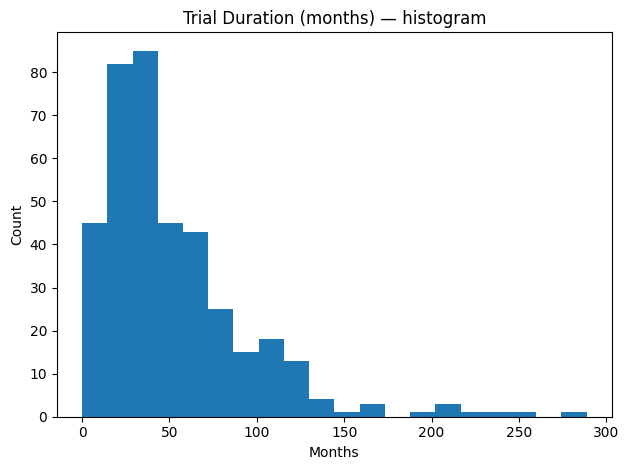

In [21]:
# Simple histogram (duration)
fig, ax = plt.subplots()
ax.hist(dur, bins=20)
ax.set_title("Trial Duration (months) — histogram")
ax.set_xlabel("Months"); ax.set_ylabel("Count")
plt.tight_layout()

## 4) ROI Scenario (illustrative) — seeded by portfolio medians

We use median **duration** and **enrollment** to seed a simple `TrialScenario`:
- Assume 6 months saved by using high-quality RWE (external controls, adaptive decisions, etc.)
- See **direct savings**, **time benefit (discounted)**, and **EV uplift**.

In [23]:
# Safe medians with fallbacks
med_enroll = int(enr.median()) if not enr.empty else 300
med_duration = float(dur.median()) if not dur.empty else 36.0

trial = TrialScenario(
    baseline_duration_months = med_duration,
    patients_treatment = med_enroll//2,
    patients_control   = med_enroll//2,
    cost_per_patient_usd = 50_000,
    prob_reg_accept_rwe  = 0.65,
    prob_reg_accept_trad = 0.55,
    discount_rate_annual = 0.10,
    monthly_benefit_usd  = 5_000_000
)
res = roi_summary(trial, months_saved_with_rwe=6)
res

{'traditional_cost': 3100000,
 'rwe_cost': 1550000,
 'savings': 1550000,
 'months_saved': 6,
 'discounted_benefit': 29180205.170280337,
 'acceptance_uplift': 0.09999999999999998,
 'ev_uplift': 5999999.999999999,
 'total_benefit': 36730205.17028034,
 'total_investment': 155000.0,
 'roi_multiple': 235.96906561471187}

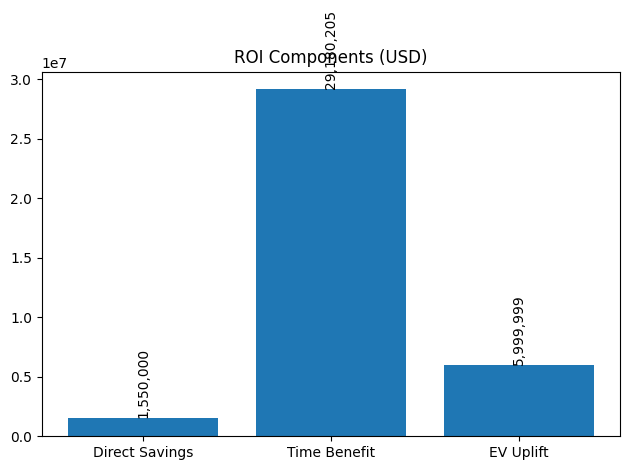

In [25]:
# Bar of ROI components
labels = ["Direct Savings", "Time Benefit", "EV Uplift"]
values = [res["savings"], res["discounted_benefit"], res["ev_uplift"]]

fig, ax = plt.subplots()
ax.bar(labels, values)
ax.set_title("ROI Components (USD)")
for i, v in enumerate(values):
    ax.text(i, v, f"{int(v):,}", ha="center", va="bottom", rotation=90)
plt.tight_layout()

## 6) Save artifacts (for reuse by other notebooks)

In [27]:
# Save flattened table and a small JSON summary for quick reuse
df.to_csv(DATA_DIR / "ctgov_v2_oncology_flat.csv", index=False)

summary = {
    "n_records": int(len(df)),
    "status_counts": status_counts.to_dict(),
    "median_duration_months": float(med_duration) if med_duration else None,
    "median_enrollment": int(med_enroll) if med_enroll else None
}
(Path(DATA_DIR) / "ctgov_summary.json").write_text(json.dumps(summary, indent=2))

print("Saved:")
print(" - data/ctgov_v2_oncology.json (raw cache)")
print(" - data/ctgov_v2_oncology_flat.csv (flattened table)")
print(" - data/ctgov_summary.json (portfolio medians, status counts)")

Saved:
 - data/ctgov_v2_oncology.json (raw cache)
 - data/ctgov_v2_oncology_flat.csv (flattened table)
 - data/ctgov_summary.json (portfolio medians, status counts)


## Notes / Next
- Filter by other TAs: change `condition="oncology"` to specific indications (e.g., `melanoma`, `nsclc`).
- Add **geo** fields (countries/locations) to refine feasibility analyses.
- Stratify by **Phase** and **OverallStatus** to compare medians by development stage.
- Wire these medians directly into your **governance scorecard Context** component (already done in Notebook 04).